# Step 1: Install Topfarm and dependencies
(don't change anything here)

In [34]:
%%capture
try:
    import topfarm
except ImportError as e:
    !pip install topfarm
try:
    import py_wake
except ImportError as e:
    !pip install py_wake
try:
    import networkx
except ImportError as e:
    !pip install networkx==2.1
import networkx
if networkx.__version__ > '2.1':
    print('Current version of OpenMDAO only supports networkx-version up to 2.1')

# Step 2: Import dependencies
(don't change anything here)

In [16]:
%matplotlib inline
import numpy as np
import topfarm
import matplotlib.pyplot as plt
from topfarm.workshop import report_result, plot_result

# Step 3: Import site data, wind turbine data and chose desired wake model from py_wake
(don't change anything here)

In [35]:
from py_wake.examples.data.iea37 import IEA37Site, IEA37_WindTurbines
from py_wake.wake_models import IEA37SimpleBastankhahGaussian
from topfarm.cost_models.py_wake_wrapper import PyWakeAEP

windTurbines = IEA37_WindTurbines()
wake_model = IEA37SimpleBastankhahGaussian(windTurbines) 
n_wt = 16
site = IEA37Site(n_wt)
site.default_ws = [9.8]
site.default_wd = np.arange(0,360,22.5)
aep_calc = PyWakeAEP(site, windTurbines, wake_model)

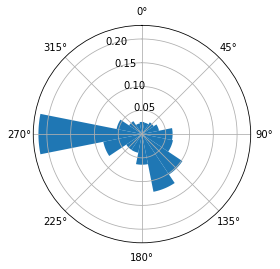

In [36]:
site.plot_wd_distribution(len(site.default_wd))

# Step 4: Set up a Topfarm optimization problem
(don't change anything here)

In [19]:
from topfarm import TopFarmProblem
from topfarm.constraint_components.boundary import CircleBoundaryConstraint
from topfarm.plotting import XYPlotComp, NoPlot

def get_topfarm(driver, plot=False):
  return TopFarmProblem(
    design_vars=dict(zip('xy', site.initial_position.T*.99)),
    cost_comp=aep_calc.get_TopFarm_cost_component(16),
    driver=driver,
    constraints=[CircleBoundaryConstraint([0, 0], 1300)],
    plot_comp=(NoPlot(), XYPlotComp())[plot]
  )


# Step 5: Choose a driver
Below you will find a list of currently implemented drivers. Pick one and tune it, but changing the arguemnts to get your first optimization results.

In [41]:
your_name = input('Please enter your name for the scorboard: ')

Please enter your name for the scorboard: Mikkel


In [ ]:
from topfarm.easy_drivers import EasyRandomSearchDriver, EasyScipyOptimizeDriver, EasySimpleGADriver
from topfarm.drivers.random_search_driver import RandomizeTurbinePosition_Circle, RandomizeTurbinePosition_Square

drivers = [
    EasyScipyOptimizeDriver(optimizer='SLSQP',maxiter=10, disp=False),
    EasyRandomSearchDriver(randomize_func=RandomizeTurbinePosition_Circle(max_step=None), max_iter=100),
    EasyRandomSearchDriver(randomize_func=RandomizeTurbinePosition_Square(max_step=None), max_iter=100),
    EasySimpleGADriver(max_gen=100, pop_size=80, Pm=0),
]
driver_no = 2

In [ ]:
@report_result(your_name)
def test():
  driver = drivers[driver_no]
  tf = get_topfarm(driver)
  return tf.optimize()

cost, state, recorder = test()

# Step 6: Take a look at your optimized configuration

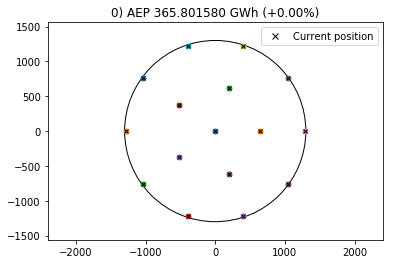

(-384.20990791837886,
 {'x': array([  503.92177963,   715.46792419,     3.45351766,  -520.60239   ,
          -459.54142359,    33.61842405,  1287.        ,  1041.204879  ,
           397.704879  ,  -397.704879  , -1041.204879  ,  -691.11204214,
         -1041.204879  ,  -298.59361329,  -867.37058181,  1041.204879  ]),
  'y': array([  111.69872343,  -942.08758939,  1015.50390169,   378.239796  ,
          -357.00624372,  -530.25318724,     0.        ,   756.479592  ,
          1224.009765  ,  1224.009765  ,   756.479592  ,   889.49628969,
          -756.479592  , -1258.38483507,  -120.73095824,  -756.479592  ])})

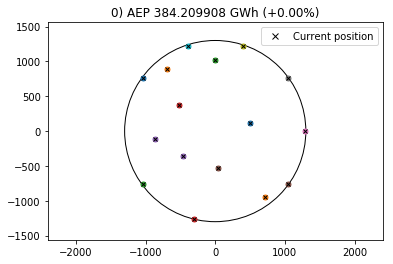

In [23]:
tf = get_topfarm(drivers[driver_no], plot=True)
tf.evaluate() # plot initial state
tf.evaluate(state) # plot final state

# Step 7: Now try with several optimizers running in succession:

In [ ]:
@report_result(your_name)
def test():
  tf = get_topfarm(EasyRandomSearchDriver(randomize_func=RandomizeTurbinePosition_Circle(), max_iter=100000))
  cost, state, recorder = tf.optimize()
  
  driver = EasyScipyOptimizeDriver(optimizer='SLSQP',tol=1e-10, maxiter=300)
  tf2 = get_topfarm(driver)
  return tf2.optimize(state)

cost, state, recorder = test()

# Step 8: Take a look at the scoreboard to see how your are doing

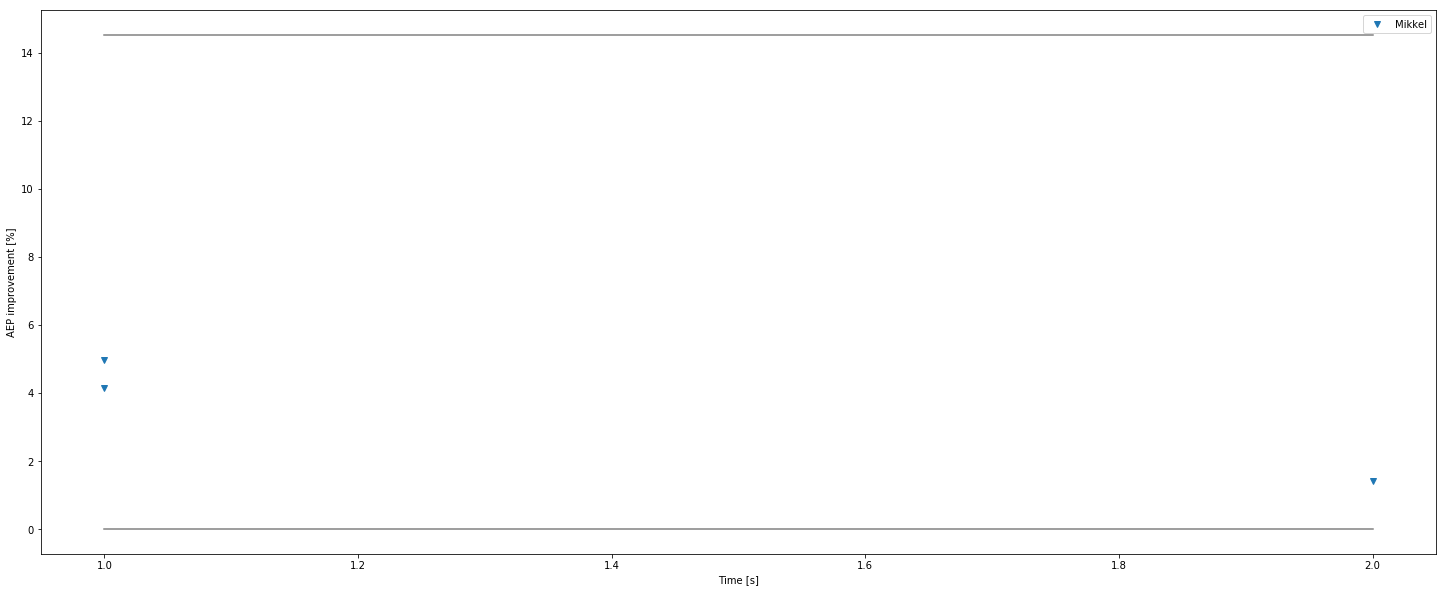

In [55]:
# plot all results
fig = plot_result()
plt.show()